# MODFLOW Tutorial 2: Unconfined Transient Flow Model

In this example, we will convert the tutorial 1 model into an unconfined,
transient flow model with time varying boundaries. Instead of using constant
heads for the left and right boundaries (by setting ibound to -1), we will use
general head boundaries. We will have the model consider the following
conditions:

* Initial conditions -- head is 10.0 everywhere
* Period 1 (1 day) -- steady state with left and right GHB stage = 10.
* Period 2 (100 days) -- left GHB with stage = 10., right GHB with stage set
  to 0.
* Period 3 (100 days) -- pumping well at model center with rate = -500., left
  and right GHB = 10., and 0.

We will start with selected model commands from the previous tutorial.


In [1]:
# ## Getting Started
#
# As shown in the previous MODFLOW tutorial, import flopy.
from pathlib import Path
from tempfile import TemporaryDirectory

In [2]:
import numpy as np

In [3]:
import flopy

## Creating the MODFLOW Model

### Define the Model Extent, Grid Resolution, and Characteristics

Assign the model information

In [4]:
Lx = 1000.0
Ly = 1000.0
ztop = 10.0
zbot = -50.0
nlay = 1
nrow = 10
ncol = 10
delr = Lx / ncol
delc = Ly / nrow
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)
hk = 1.0
vka = 1.0
sy = 0.1
ss = 1.0e-4
laytyp = 1

Variables for the BAS package
Note that changes from the MODFLOW tutorial 1

In [5]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
strt = 10.0 * np.ones((nlay, nrow, ncol), dtype=np.float32)

### Define the Stress Periods

To create a model with multiple stress periods, we need to define nper,
perlen, nstp, and steady.  This is done in the following block in a manner
that allows us to pass these variable directly to the discretization object:

In [6]:
nper = 3
perlen = [1, 100, 100]
nstp = [1, 100, 100]
steady = [True, False, False]

### Create Time-Invariant Flopy Objects

With this information, we can now create the static flopy objects that do
not change with time:

In [7]:
temp_dir = TemporaryDirectory()
workspace = temp_dir.name
name = "tutorial02_mf"
mf = flopy.modflow.Modflow(name, exe_name="mf2005", model_ws=workspace)
dis = flopy.modflow.ModflowDis(
    mf,
    nlay,
    nrow,
    ncol,
    delr=delr,
    delc=delc,
    top=ztop,
    botm=botm[1:],
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    steady=steady,
)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowLpf(
    mf, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53
)
pcg = flopy.modflow.ModflowPcg(mf)

### Transient General-Head Boundary Package

At this point, our model is ready to add our transient boundary packages.
First, we will create the GHB object, which is of the following type:
`flopy.modflow.ModflowGhb()`.

The key to creating Flopy transient boundary packages is recognizing that
the boundary data is stored in a dictionary with key values equal to the
zero-based stress period number and values equal to the boundary conditions
for that stress period.  For a GHB the values can be a two-dimensional nested
list of `[layer, row, column, stage, conductance]`.

In [8]:
stageleft = 10.0
stageright = 10.0
bound_sp1 = []
for il in range(nlay):
    condleft = hk * (stageleft - zbot) * delc
    condright = hk * (stageright - zbot) * delc
    for ir in range(nrow):
        bound_sp1.append([il, ir, 0, stageleft, condleft])
        bound_sp1.append([il, ir, ncol - 1, stageright, condright])
print("Adding ", len(bound_sp1), "GHBs for stress period 1.")

Adding  20 GHBs for stress period 1.


In [9]:
# Make list for stress period 2
stageleft = 10.0
stageright = 0.0
condleft = hk * (stageleft - zbot) * delc
condright = hk * (stageright - zbot) * delc
bound_sp2 = []
for il in range(nlay):
    for ir in range(nrow):
        bound_sp2.append([il, ir, 0, stageleft, condleft])
        bound_sp2.append([il, ir, ncol - 1, stageright, condright])
print("Adding ", len(bound_sp2), "GHBs for stress period 2.")

Adding  20 GHBs for stress period 2.


In [10]:
# We do not need to add a dictionary entry for stress period 3.
# Flopy will automatically take the list from stress period 2 and apply it
# to the end of the simulation
stress_period_data = {0: bound_sp1, 1: bound_sp2}

In [11]:
# Create the flopy ghb object
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=stress_period_data)

### Transient Well Package

Now we can create the well package object, which is of the type,
`flopy.modflow.ModflowWel()`.

In [12]:
# Create the well package
# Remember to use zero-based layer, row, column indices!
pumping_rate = -500.0
wel_sp1 = [[0, nrow / 2 - 1, ncol / 2 - 1, 0.0]]
wel_sp2 = [[0, nrow / 2 - 1, ncol / 2 - 1, 0.0]]
wel_sp3 = [[0, nrow / 2 - 1, ncol / 2 - 1, pumping_rate]]
stress_period_data = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data)

### Output Control

Here we create the output control package object, which is of the
type `flopy.modflow.ModflowOc()`.

In [13]:
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = [
            "save head",
            "save drawdown",
            "save budget",
            "print head",
            "print budget",
        ]
oc = flopy.modflow.ModflowOc(
    mf, stress_period_data=stress_period_data, compact=True
)

## Running the Model

Run the model with the run_model method, which returns a success flag and
the stream of output. With run_model, we have some finer control, that
allows us to suppress the output.

In [14]:
# Write the model input files
mf.write_input()

In [15]:
# Run the model
success, mfoutput = mf.run_model(silent=True, pause=False)
assert success, "MODFLOW did not terminate normally."

## Post-Processing the Results

Once again, we can read heads from the MODFLOW binary output file, using
the `flopy.utils.binaryfile()` module. Included with the HeadFile object
are several methods that we will use here:

* `get_times()` will return a list of times contained in the binary head file
* `get_data()` will return a three-dimensional head array for the specified
  time
* `get_ts()` will return a time series array `[ntimes, headval]` for the
  specified cell

Using these methods, we can create head plots and hydrographs from the
model results.

In [16]:
# Imports
import matplotlib.pyplot as plt

In [17]:
import flopy.utils.binaryfile as bf

In [18]:
# Create the headfile and budget file objects
headobj = bf.HeadFile(Path(workspace) / f"{name}.hds")
times = headobj.get_times()
cbb = bf.CellBudgetFile(Path(workspace) / f"{name}.cbc")

In [19]:
# Setup contour parameters
levels = np.linspace(0, 10, 11)
extent = (delr / 2.0, Lx - delr / 2.0, delc / 2.0, Ly - delc / 2.0)
print("Levels: ", levels)
print("Extent: ", extent)

Levels:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Extent:  (50.0, 950.0, 50.0, 950.0)


In [20]:
# Well point for plotting
wpt = (450.0, 550.0)

Create a figure with maps for three times

*****Processing time:  1.0
Head statistics
  min:  10.0
  max:  10.0
  std:  0.0
*****Processing time:  101.0
Head statistics
  min:  0.025931068
  max:  9.998436
  std:  3.2574987
*****Processing time:  201.0
Head statistics
  min:  0.016297927
  max:  9.994038
  std:  3.1544707


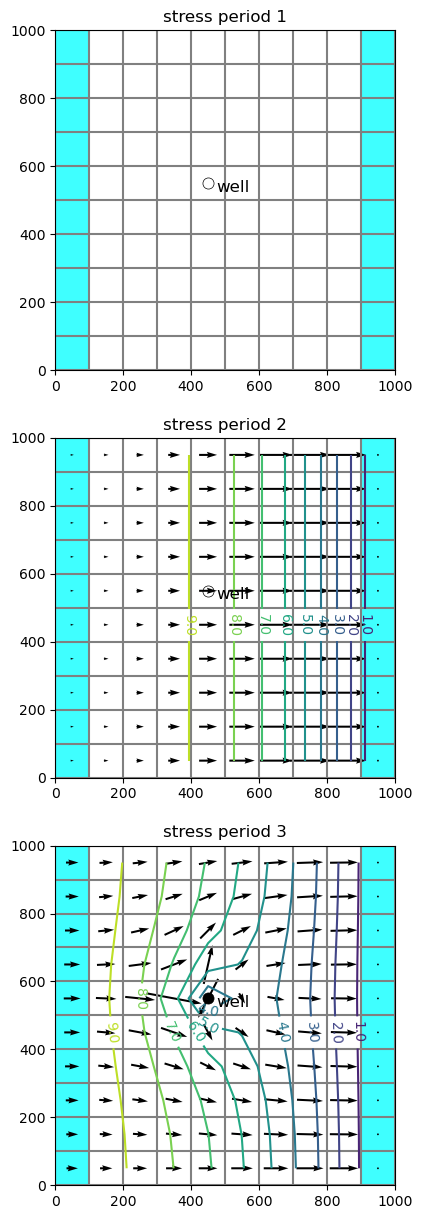

In [21]:
# Make the plots
fig = plt.figure(figsize=(5, 15))
mytimes = [1.0, 101.0, 201.0]
for iplot, time in enumerate(mytimes):
    print("*****Processing time: ", time)
    head = headobj.get_data(totim=time)
    # Print statistics
    print("Head statistics")
    print("  min: ", head.min())
    print("  max: ", head.max())
    print("  std: ", head.std())

    # Extract flow right face and flow front face
    frf = cbb.get_data(text="FLOW RIGHT FACE", totim=time)[0]
    fff = cbb.get_data(text="FLOW FRONT FACE", totim=time)[0]

    # Create a map for this time
    ax = fig.add_subplot(len(mytimes), 1, iplot + 1, aspect="equal")
    ax.set_title(f"stress period {iplot + 1}")

    pmv = flopy.plot.PlotMapView(model=mf, layer=0, ax=ax)
    qm = pmv.plot_ibound()
    lc = pmv.plot_grid()
    qm = pmv.plot_bc("GHB", alpha=0.5)
    if head.min() != head.max():
        cs = pmv.contour_array(head, levels=levels)
        plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
        quiver = pmv.plot_vector(frf, fff)

    mfc = "None"
    if (iplot + 1) == len(mytimes):
        mfc = "black"
    ax.plot(
        wpt[0],
        wpt[1],
        lw=0,
        marker="o",
        markersize=8,
        markeredgewidth=0.5,
        markeredgecolor="black",
        markerfacecolor=mfc,
        zorder=9,
    )
    ax.text(wpt[0] + 25, wpt[1] - 25, "well", size=12, zorder=12)

Create a hydrograph

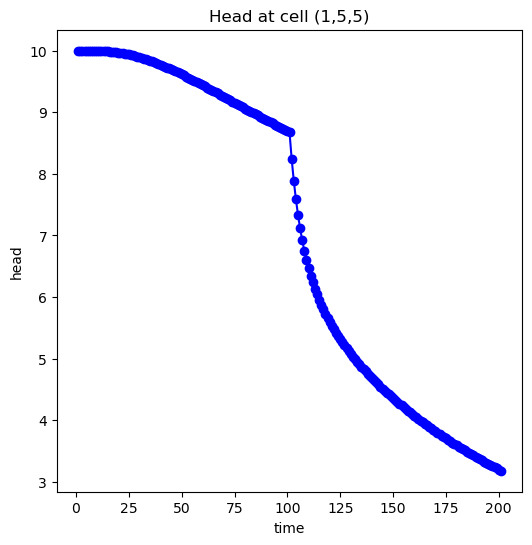

In [22]:
# Plot the head versus time
idx = (0, int(nrow / 2) - 1, int(ncol / 2) - 1)
ts = headobj.get_ts(idx)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ttl = f"Head at cell ({idx[0] + 1},{idx[1] + 1},{idx[2] + 1})"
ax.set_title(ttl)
ax.set_xlabel("time")
ax.set_ylabel("head")
ax.plot(ts[:, 0], ts[:, 1], "bo-")

In [23]:
try:
    temp_dir.cleanup()
except:
    # prevent windows permission error
    pass